In [1]:
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading necessary libraries to build and train model                       │
└──────────────────────────────────────────────────────────────────────────"""
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import os,sys,gc
import numpy as np
import pickle
import torch
import proplot as plot
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import glob
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/2024_TCG_VED/')
from util import derive_var,read_and_proc,ts_models,benchmark
import properscoring as ps
from copy import deepcopy
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})
import random

# Basic Settings

In [2]:
# Setting up seed so that results are reproducible
benchmark.setup_seed(8888)

# Setting up path where things are stored
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
suffixRAD = '_smooth_preproc_dict1b_g_radcomp'

# Pressure level
preslv = np.linspace(1000,100,10)

In [3]:
storedata,store_notensor = {},{}
for i in tqdm(range(0,40)):
    storedata[i] = benchmark.prepare_tensors('../processed/haiyan_store',i,23,'No')
    store_notensor[i] = benchmark.prepare_tensors('../processed/haiyan_store',i,23,'Yes')

  0%|          | 0/40 [00:00<?, ?it/s]

# Read in model, make predictions, and calculate performance metrics

## VAE

In [4]:
# Basic Settings for the wrapper to get the full model predictions and basic performance metrics
losscoeffs = [0.45,0.55,0.65,0.75,0.85,0.95,1] #lambda term in the loss function
numsplit = 40 #Number of splits we have trained
trailnums = 30 #Multiple iteration of model predictions are saved to get the prediction spread
seeds = np.random.randint(0, 500,size=20) #Choose 20 seeds randomly to run model inference

# Save results in a dictionary
# Performance metrics to be saved: CRPS score; Save prediction spread
seeds_store = {}
for seed in seeds:
    crps_store_vae = {}
    for losscoeff in tqdm(losscoeffs):
        if (losscoeff==1):
            suffix=None
        else:
            suffix='_*best*'
        crps_store_vae[losscoeff] = benchmark.get_performances_vae(datasets=storedata,datasets_notensor=store_notensor,numsplits=numsplit,modelpath='../processed/haiyan_store/vae/losscoeff_'+str(losscoeff)+'/',suffix=suffix,
                                                                   droprate=None,metric='crps',trailnums=trailnums,withspread=True,output_type='vae',seed=seed)
    seeds_store[seed] = crps_store_vae

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

# Choose the best model

In [5]:
# Get the SSREL score for all the models, with different seeds, split, and initialization
allsave = []
for snumz in tqdm(np.linspace(0,19,20)):
    tmpsave_1 = {}
    for coeffz in losscoeffs:
        tmpsave_2 = []
        for splitnoz in range(39):
            snumz=int(snumz)
            tempsNUM = len(seeds_store[seeds[snumz]][coeffz][splitnoz]['truth'])
            tmpsave_3 = [benchmark.get_spread_skill_score_model(seeds_store=seeds_store,seeds=seeds,snum=snumz,coeff=coeffz,splitno=splitnoz,modelno=i,category='valid',meancat='meanvals') for i in range(tempsNUM)]
            tmpsave_2.append(tmpsave_3)
        tmpsave_1[coeffz] = tmpsave_2
    allsave.append(tmpsave_1)
    
# Save the minimum SSREL score for models with different splits and initialization    
ssRels_array = np.zeros((39,9))
for i in (range(39)):
    for j in (range(9)):
        ssRels_array[i,j] = np.asarray([allsave[k][0.85][i][j]['ssRel'] for k in range(20)]).min()

  0%|          | 0/20 [00:00<?, ?it/s]

In [6]:
# Find the split and initialization that produce the lowest SSREL score
minsplit,minmodel = np.argwhere(ssRels_array == np.min(ssRels_array))[0][0],np.argwhere(ssRels_array == np.min(ssRels_array))[0][1]

# Find the seed number that produces the lowest SSREL score for a given split and initialization
minseed = np.asarray([allsave[k][0.85][minsplit][minmodel]['ssRel'] for k in range(20)]).argmin()

In [7]:
# Read in the best model
bestmodel = seeds_store[seeds[minseed]][0.85][minsplit]['models'][minmodel]

# Calculate the effective weights (see SI for details); -40 and -20 are the indices of the longwave PCs in the input data
ALW = benchmark.analysis_patterns(None,None).new_coeff_vae(store_notensor[minsplit]['train'][0],bestmodel,'LW',[-40,-20])
ASW = benchmark.analysis_patterns(None,None).new_coeff_vae(store_notensor[minsplit]['train'][0],bestmodel,'SW',[-40,-20])

# Calculate the overall bias (see SI for details)
B = benchmark.analysis_patterns(None,None).new_b_vae(store_notensor[minsplit]['train'][0],bestmodel,[-40,-20])

# PCA objects produced by the scikit-learn library
pcalw,pcasw = read_and_proc.depickle('../processed/haiyan_store/pca/lw/'+str(minsplit)+'/PCA3D.pkg'),read_and_proc.depickle('../processed/haiyan_store/pca/sw/'+str(minsplit)+'/PCA3D.pkg')

# Weights to get the $\Pi_{\mu, LW}$, $\Pi_{\mu, SW}$ structures from the SI equations
fl = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[minsplit]['train'][0],bestmodel,'LW')
flsw = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[minsplit]['train'][0],bestmodel,'SW')

# getting the 3D mean and log(sigma^2) structures with the weights
flas = np.squeeze(np.dot(fl,pcalw['lw'].components_[:20,:])).reshape(10,360,208)
flas_sw = np.squeeze(np.dot(flsw,pcasw['sw'].components_[:20,:])).reshape(10,360,208)

# Read in raw radiation field and get the anomaly

In [10]:
import importlib
importlib.reload(read_and_proc)

<module 'util.read_and_proc' from '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/2024_TCG_VED/util/read_and_proc.py'>

In [8]:
# Read in the saved processed WRF longwave and shotwave outputs
haiyan_lw = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/radcomp/'+'mem'+str(lime)+suffixRAD)['LW'] for lime in tqdm(range(1,21))]
haiyan_sw = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/radcomp/'+'mem'+str(lime)+suffixRAD)['SW'] for lime in tqdm(range(1,21))]
# Read in the split specification (saved in a pickle file)
so = read_and_proc.depickle('../splitname.pkl')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [12]:
# Divide the data into training, validation, and test sets
aaaaa = read_and_proc.train_valid_test(haiyan_lw,[int(so[minsplit][0]),int(so[minsplit][1])],[int(so[minsplit][2]),int(so[minsplit][3])],'Yes')
# Creating the training mean longwave and shortwave structures
MEANLW = np.mean(np.mean(aaaaa[0],axis=0).reshape(10,360,208),axis=1)
MEANSW = np.mean(np.mean(read_and_proc.train_valid_test(haiyan_sw,[int(so[minsplit][0]),int(so[minsplit][1])],[int(so[minsplit][2]),int(so[minsplit][3])],'Yes')[0],axis=0).reshape(10,360,208),axis=1)

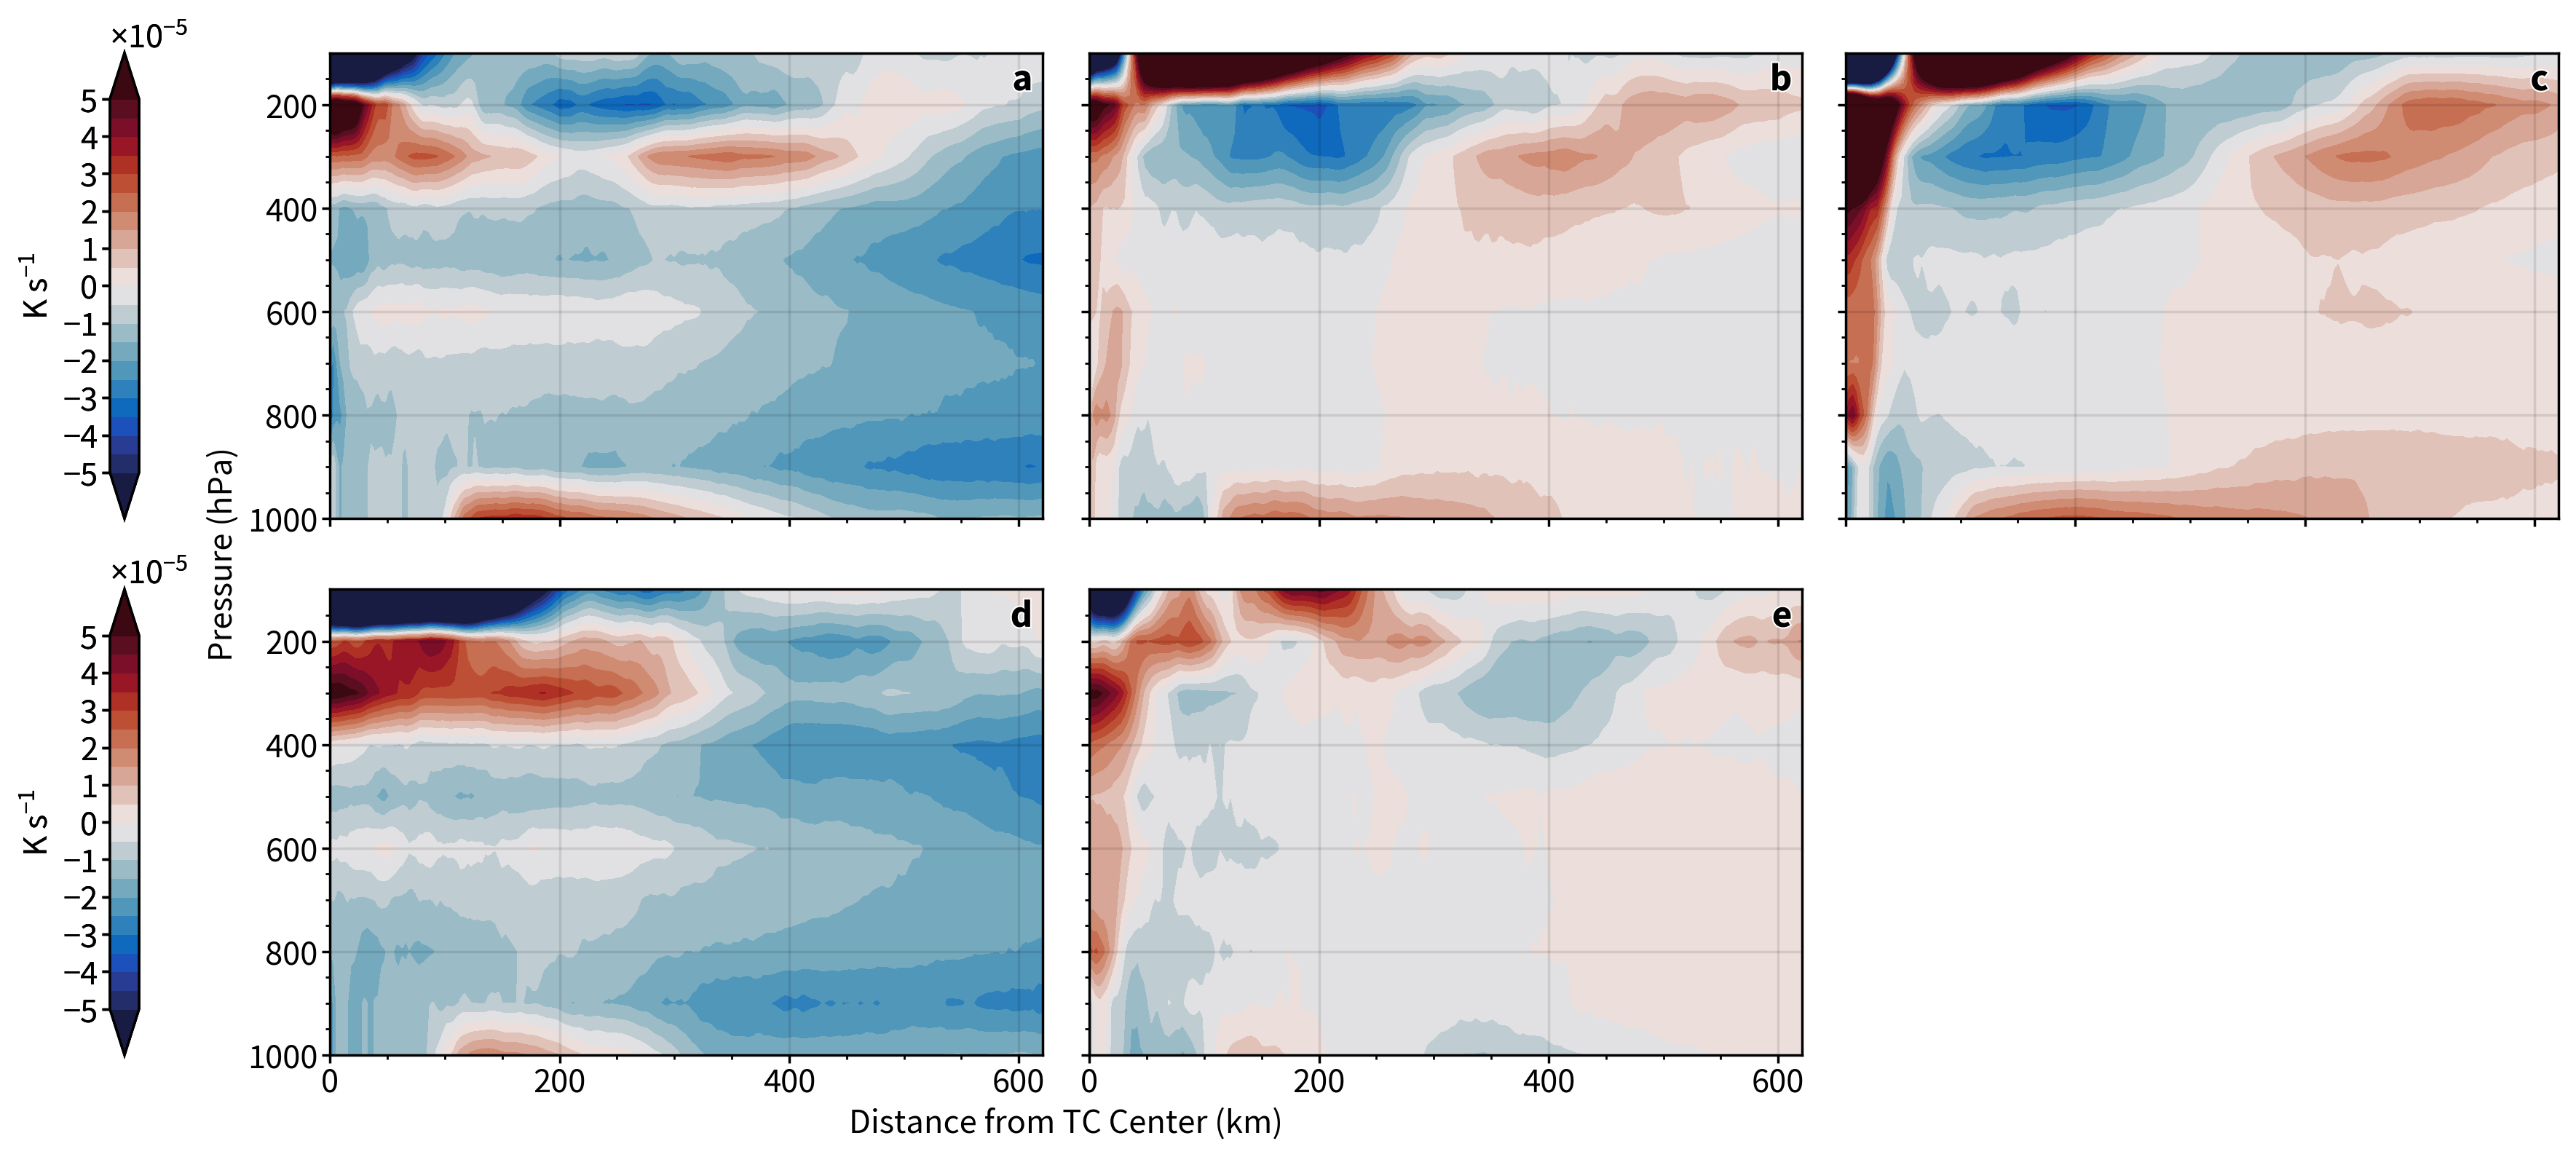

In [13]:
preslv = np.linspace(1000,100,10)
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 17.5,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig,axs = plot.subplots(ncols=3,nrows=2,axwidth=4.895,refaspect=1.531)
axs.format(abc=True,abcloc='ur')

# Raw longwave field for First Sample
img = axs[0].contourf(np.linspace(0,flas.shape[2]-1,flas.shape[2])*3,(preslv),np.mean(haiyan_lw[2][16].reshape(10,360,208),axis=1),cmap='balance',levels=np.linspace(-0.5e-4,0.5e-4,21),extend='both')
axs[0].colorbar(img,loc='l',label='K s$^{-1}$')
axs[0].format(xlabel='Distance from TC Center (km)',ylabel='Pressure (hPa)')
# Raw longwave field for first sample, subtracting training mean
img = axs[1].contourf(np.linspace(0,flas.shape[2]-1,flas.shape[2])*3,(preslv),np.mean(haiyan_lw[2][16].reshape(10,360,208),axis=1)-MEANLW,cmap='balance',levels=np.linspace(-0.5e-4,0.5e-4,21),extend='both')
axs[1].format(xlabel='Distance from TC Center (km)',ylabel='Pressure (hPa)')

# Pi_{mu, LW}
axs[2].contourf(np.linspace(0,flas.shape[2]-1,flas.shape[2])*3,(preslv),np.mean(flas,axis=1),cmap='balance',levels=np.linspace(-1.5e-3,1.5e-3,21),extend='both')
axs[2].format(xlabel='Distance from TC Center (km)',ylabel='Pressure (hPa)')

# Raw longwave field for Second Sample
img = axs[0+3].contourf(np.linspace(0,flas.shape[2]-1,flas.shape[2])*3,(preslv),np.mean(haiyan_lw[11][16].reshape(10,360,208),axis=1),cmap='balance',levels=np.linspace(-0.5e-4,0.5e-4,21),extend='both')
axs[0+3].colorbar(img,loc='l',label='K s$^{-1}$')
axs[0+3].format(xlabel='Distance from TC Center (km)',ylabel='Pressure (hPa)')
# Anomaly longwave field for Second Sample
img = axs[1+3].contourf(np.linspace(0,flas.shape[2]-1,flas.shape[2])*3,(preslv),np.mean(haiyan_lw[11][16].reshape(10,360,208),axis=1)-MEANLW,cmap='balance',levels=np.linspace(-0.5e-4,0.5e-4,21),extend='both')
axs[1+3].format(xlabel='Distance from TC Center (km)',ylabel='Pressure (hPa)')

# Remove empty figure
axs[5].set_visible(False)

axs.format(abc=True,abcloc='ur')
plt.show()